# Generation of 1D profiles to percolate liquid through

I want to generate a range of 1D profiles for exploring how variability impact porosity. To do this I will build on the example of [Lukas Mosser](https://github.com/LukasMosser/roeth_tarantola_blog_series) and instead of having layers of velocity, I will have layers of permeability.

Fluid will migrate vertically through my matrix by D'Arcy flow,
$$ \partial_{t} \phi + \partial_{z} (\phi v) = 0 $$
where,
$$ \phi v = \frac{k}{\eta} \Delta\rho g $$
In these coupled equations the permeability, $k$, is a function of the porosity, and to keep things simple I will assume it is just a linear function,
$$ k = k_{0}\phi $$
where $k_{0}$ is the permeability coefficient.

So just for fun, I will build a series of 1D profiles and then percolate fluid through them to see how sensative the model is to spatial variation in $k_{0}$.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch

### The layers

I will have 5 layers each being 10 km thick. Permeability will be linearly increasing with depth.

In [2]:
lx = 10000 # length of model space (m)
nx = 100 # number of cells in x
lz = 50000 # depth of model space (m)
nz = 5 # number of cells in z
dz = int(lz/nz) # discretisation
dx = lx/nx # discretisation
n_layers = 5 # number of layers
k0 = 1e-7 # permeability at top
dk_const = 1e-8 # permeability increase

### Define the probability distribution

Just start with a uniform distribution using pytorch. Set the initial seed to 42.

In [3]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

dk = torch.distributions.Uniform(low=-1,high=1)

Because I am using pytorch to generate the model I will create a container to store the permeabilities in

In [64]:
model = torch.ones(nz,1)

kl = k0 + dk_const*dk.sample()
for i in range(0, n_layers):
    model[dz*i:dz*(i+1)] = kl
    kl = (kl - dk_const) + dk_const*dk.sample()
    print("Layer ", i+1, " at depth ", dz*i, "[m] has permeability of %3.1e" % kl.item())

Layer  1  at depth  0 [m] has permeability of 8.0e-08
Layer  2  at depth  10000 [m] has permeability of 7.5e-08
Layer  3  at depth  20000 [m] has permeability of 7.4e-08
Layer  4  at depth  30000 [m] has permeability of 6.0e-08
Layer  5  at depth  40000 [m] has permeability of 5.4e-08


In an effort to improve lets make that into a function, just like in the example.

In [65]:
def sample_model_N_times(k0,dk_const,n_layers,nz,N):
    models = []
    permeabilities = []
    for i in range(N):
        model_true = torch.ones(nz,1)

        kl = k0 + dk_const*dk.sample()
        k_temp = []
        for i in range(0, n_layers):
            k_temp.append(kl)
            model_true[dz*i:dz*(i+1)] = kl
            kl = (kl - dk_const) + dk_const*dk.sample()
        permeabilities.append(torch.stack(k_temp, 0))
        models.append(model_true)
        
    models_th = torch.stack(models, 0)
    permeabilities_th = torch.stack(permeabilities, 0) 
    return models_th, permeabilities_th

In [66]:
earth_models_th, layer_permeabilities_th = sample_model_N_times(k0,dk_const,n_layers,nz,1)

print(earth_models_th.size())
print(layer_permeabilities_th.size())
print(layer_permeabilities_th)

torch.Size([1, 5, 1])
torch.Size([1, 5])
tensor([[1.0488e-07, 1.0292e-07, 9.1783e-08, 8.2098e-08, 7.9445e-08]])


Call the function to make a nice number of models, say 100:

In [67]:
N = 100
earth_models_th, layer_permeabilities_th = sample_model_N_times(k0,dk_const,n_layers,nz,N)

Now plot them:

In [68]:
def plot_profiles(y,layers,N):
    for j in range(N):
        x = []
        z = []
        z_ = 0
        for i in range(layers):
            z.append(z_)
            z_ += dz
            x.append(y.numpy()[j][i])
            z.append(z_)
            x.append(y.numpy()[j][i])

        plt.plot(x,z,'black')

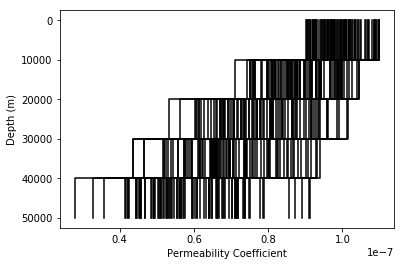

In [69]:
plot_profiles(layer_permeabilities_th,n_layers,N)
plt.gca().invert_yaxis()
plt.xlabel('Permeability Coefficient')
plt.ylabel('Depth (m)')
plt.show()

Cool, now to let fluid percolate through the 1D column... TO DO: translate the TVD matlab function to python...